
### 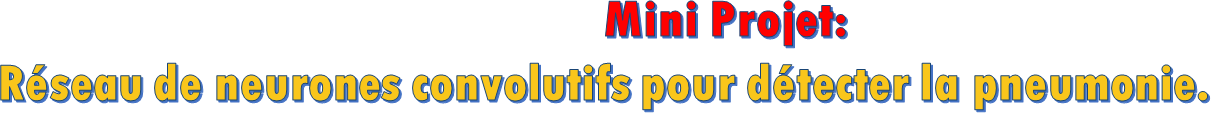



la  base contient ***5840*** images que j'ai  répartir à 90% et 10 % entre le jeu d'entraînement et le jeu de
test c'est-à-dire que  je vais utiliser ***5220*** images pour entrainer le réseau et ***620*** pour tester s'il a bien appris ou
non.


In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:

# Emplacement de mon ensemble de données sur Mon Google Drive 
image_path = "drive/MyDrive/DATA"
image_test ="drive/MyDrive/DATA/pnomoniaData/test"
image_train="drive/MyDrive/DATA/pnomoniaData/train"


Pour construire notre réseau de neurones à convolution, je vais  d'abord importer quelques modules de
Keras

---



In [18]:
#chargement des modules 
import os
import glob as gb
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

#import seaborn as sns
#from tqdm import tqdm
#from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
#from keras.models import Model, load_model

 

from keras.preprocessing.image import ImageDataGenerator

In [19]:

INIT_LR = 1e-3  
EPOCHS = 10
BS = 8

###**Augmentation en temps réel du nombre d'image**

-



 Ce
processus d'augmentation d'images va nous permettre d'éviter le problème de sur-apprentissage. En effet,
quand on n'a pas assez de données dans mon  jeu d'entraînement, le modèle devient très fort sur le jeu
d'entraînement mais il n'arrive pas vraiment à trouver les caractéristiques qui vont lui permettre de se
généraliser sur le jeu de test.

alors je peut utiliser la fonction ***ImageDataGenerator()*** de Keras
qui permet de générer de nouvelles images à partir des images de base par application de transformations
géométriques simples telles que: la rotation, la zoom, l'effet miroir, l'étirement, …etc. Grâce à cette
augmentation artificielle du nombre d'images, je vais pouvoir réduire le risque de surentraînement et donc
d'améliorer le  modèle.
La première étape de création de nouvelles images à partir des images de base consiste à créer deux objets
(générateurs) ***train_datagen*** et ***test_datagen ***grâce à la fonction ***ImageDataGenerator()***.




In [20]:
# Création d'un générateur d'images pour le jeu d'entrainement
train_datagen = ImageDataGenerator(
 rescale=1./255,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True)

In [21]:
# Création d'un générateur d'images pour le jeu de test
test_datagen = ImageDataGenerator(rescale=1./255)

L' étape suivante consiste à utiliser la méthode ***flow_from_directory() ***sur les objet*** train_datagen*** et
***test_datagen*** pour générer de nouvelles images en temps réel à partir du jeu d'entrainement et du jeu de
test. 


In [22]:
# Chargement des images d'entrainement
training_set = train_datagen.flow_from_directory(
 'drive/MyDrive/DATA/pnomoniaData/train',
 target_size=(224, 224),
 batch_size=BS,
 class_mode='binary')

# Chargement des images de test
test_set = test_datagen.flow_from_directory(
 'drive/MyDrive/DATA/pnomoniaData/test',
 target_size=(224,224), 
 class_mode='binary')

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Pour construire un réseau de neurones à convolution, je vais créer un nouveau objet que je  vais  nommer
***classifier*** de type Sequeltial. Cet objet va être le  réseau de neurones

In [34]:
# Création d'un réseau de neurones
classifier = Sequential()

###**Définition de l'architecture du** **réseau**

Le réseau de neurones à convolution est constitué de 4 couches, la couche de Convolution, la couche de
Pooling, la couche de Flattening et la couche Complétement connectée.

### Etape 1: Convolution 

> 



La convolution consiste à appliquer un filtre (Feature Detector) sur l'image qui permet comme son nom
l'indique de détecter et de ressortir des caractéristiques de l'image et la transformer en une carte de
caractéristiques (Features Map)


Pour réaliser ceci , je vais  utiliser la méthode **add()** sur l' objet **classifier** .
Cette méthode prend en paramètre d'entrée la méthode Conv2D().


In [35]:
# Création de la couche de convolution
classifier.add(Conv2D(32, (3,3), input_shape=(224,224,3), activation = 'relu')) 

###Etape 2: MaxPooling

Elle consiste à réduire la dimension des **Features Maps** tout en conservant les informations les plus importantes.
Comme le montre l’exemple suivant, l'image est découpée en fenêtre de 2x2 pixels dans lesquelles seul le pixel
de plus grande valeur sera conservé.


Pour implémenter cette opération, je vais utiliser la même méthode** add()** puisque je vais 
rajouter une couche, sauf que cette fois je vais utiliser ala fonction **Maxpauling2D** comme paramètre
d'entrée. 


In [36]:
# Création de la couche de Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2))) 
# Ajout d'une seconde couche de convolution et de pooling
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2))) 

# Ajout d'une seconde couche de convolution et de pooling

classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2))) 

###Etape 3: Flattening

Elle consiste à prendre toutes les valeurs de tous les Pool Features Maps en partant de en haut à
gauche et de gauche à droite puis les mettre tous dans une colonne ce qui donne un vecteur énorme
qui va servir de couche d'entrée d'un prochain réseau de neurones artificiels entièrement connectés. 

Pour implémenter cette opération , je vais  utiliser la même méthode toujours **add()**
puisque je vais  rajouter une couche, sauf que cette fois je vais  utiliser  la fonction **Flatten()** comme
paramètre d'entrée. 


In [37]:
# Création de la couche de Flattening
classifier.add(Flatten()) 


###Etape 4: Couche complétement connectée 


Puisque l'objectif est faire des prédictions alors je vais ajouter un réseau de neurones artificiels
complétement connecté avec comme entrée, le vecteur de caractéristiques que j'ai obtenu après l'étape de
Flattening. Le rôle de ce réseau est de trouver les combinaisons intéressantes de caractéristiques qui
permettent de distinguer les images normaux et de pneumonie


je vais ajouter une première couche cachée avec la
méthode **add()** et **Dense()** de l'objet **classifier**

In [38]:


# Création de la première couche cachée
classifier.add(Dense(units = 256, activation = 'relu')) 
               
classifier.add(Dense(units = 128, activation = 'relu')) 

classifier.add(Dense(units = 64, activation = 'relu')) 
               
classifier.add(Dense(units = 16, activation = 'relu')) 




puisque je suis  dans le cas d'une classification
binaire, je vais utiliser un seul neurone dans la couche de sortie.

In [39]:
# Création de la couche de sortie
classifier.add(Dense(units = 1, activation = 'sigmoid')) 


####Définition des paramètres du réseau de neurones


Maintenant que j'ai définit l'architecture de réseau de neurones, je vais spécifier la fonction
coût et la méthode qui va permettre au réseau d'ajuster ses poids. Pour faire ceci j' utilisera la fonction
**compile()** de la manière suivante:

In [40]:
##########################
#from keras.layers import Dropout
#classifier.add(Dropout(0.5))
#####################

# Compilation du réseau de neurones
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy']) 

###Entrainement du réseau de neurones à convolution 

Maintenant que je vais définit l'architecture et les paramètres de notre réseau de neurones, je vais 
passer à l'étape d'entrainement et de validation. Pour ce faire j' utilisera la méthode **fit_generator()** du
**classifier**.

In [31]:
# Création d'un réseau de neurones
classifier = Sequential()

# Création de la couche de convolution
classifier.add(Conv2D(32, (3,3), input_shape=(224,224,3), activation = 'relu')) 

# Création de la couche de Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2))) 


# Ajout d'une seconde couche de convolution et de pooling
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2))) 

# Ajout d'une seconde couche de convolution et de pooling
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2))) 

# Création de la couche de Flattening
classifier.add(Flatten()) 

# Création de la première couche cachée
classifier.add(Dense(units = 256, activation = 'relu')) 
               
classifier.add(Dense(units = 128, activation = 'relu')) 

classifier.add(Dense(units = 64, activation = 'relu')) 
               
classifier.add(Dense(units = 16, activation = 'relu')) 

# Création de la couche de sortie
classifier.add(Dense(units = 1, activation = 'sigmoid')) 

# Compilation du réseau de neurones
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy']) 

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

classifier.fit_generator(training_set,steps_per_epoch=100,epochs = EPOCHS,validation_data = test_set,validation_steps=200,callbacks=[early_stopping]
                        ) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
 45/100 [============>.................] - ETA: 9s - loss: 0.8035 - accuracy: 0.7739

KeyboardInterrupt: ignored

Les résultats montre qu'on a une précision de **90% **sur le jeu 
 de test . En générale lorsqu'on construit un
réseau de neurones, ce qui est  intéraisant  vraiment c'est sa précision sur le jeu de test c'est à dire sa capacité à
généraliser ses prédictions sur de nouvelles données

# matrice du confusion 

In [ ]:

#Confution Matrix and Classification Report
Y_pred = classifier.predict_generator(test_set, 20)
#y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred.round())) 
#print('Classification Report')
#target_names = ['NORMAL', 'PNOM']
#print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Une fois que le  réseau classifier entraîné, on peut faire les prédictions. Il suffit d'utiliser **predict()** du
classifier sur l'une des images qui se trouve dans le dossier 'drive/MyDrive/DATA/pnomoniaData/train/..'.

 puis on prend  une photo d'un personne normal  et une photo d'un personne attient une pneumonie  puis  on essaie de prédire lequel est un personne normal  et lequel est un personne atteint le pneumonie 
avec le modèle de réseau de neurones à convolution que j'ai  construit.


In [33]:
import numpy as np
from keras.preprocessing import image
# Chargement de l'image
test_image = image.load_img('drive/MyDrive/DATA/pnomoniaData/train/PNOM/person1308_virus_2252.jpeg',
 target_size = (224, 224))
# Transformation de l'image en une matrice et normalisation des pixels
test_image = image.img_to_array(test_image)
# Faire apparaitre la troisième dimension
test_image = np.expand_dims(test_image, axis = 0)
# Prédiction  
result = classifier.predict(test_image)
# Affichage de l'indice de classe
training_set.class_indices
if result[0][0] > 0.5:
 	prediction = ' pnomonia'
else:
	prediction = 'normal' 

#realisation
print(prediction) 









 pnomonia
